**ЗАДАЧА**

Напомним, что вам предстоит выяснить, от каких самых малоприбыльных рейсов из Анапы мы можем отказаться в зимнее время. Вы не знаете, по каким критериям ваше руководство будет отбирать рейсы, поэтому решаете собрать как можно больше информации, содержащейся в вашей базе, в один датасет. 

Исходя из того, что прибыльность рейса — это разница между доходом от продаж билетов и расходом на полет, соберите такой датасет, который позволит оценить эти цифры. 

Самая простая модель оценки прибыльности: стоимость билетов - стоимость топлива на рейс (для оценки последнего вам необходим километраж рейса или длительность полета), но вы можете предложить другую модель.

Ваш датасет должен обязательно включать id рейса и города вылета (Анапа) и прилета. Он также  может включать такие данные, как модель самолёта и его характеристики, суммарную стоимость всех билетов на рейсе, затраченное время в полёте и прочее — на ваше усмотрение.

Важно! Не все данные, необходимые для решения задачи, есть в вашей базе. Соберите всё, что есть — остальное дополнят специалисты, которые будут проводить анализ.


**ПРЕЗЕНТАЦИЯ**

Помимо датасета и кода с решением вам нужно подготовить презентацию на 5-6 слайдов, которую вы будете использовать для защиты своего решения перед центральным офисом. Презентация должна содержать:
* Структуру вашего датасета.
* Описание данных и их отношение к оценке прибыльности.
* Данные, которые можно добавить в вашу таблицу, но вы не нашли их в базе данных.
* Возможные способы оценки прибыльности рейсов на основе вашего датасета.


In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [89]:
df = pd.read_csv('airflights.csv')

In [90]:
#создадим функции для визуализации признаков:
def get_num(df, feature):
  '''for numeric features'''
  plt.figure(figsize=(15, 5))
  plt.subplot(121)
  plt.hist(x=df[feature].dropna())
  plt.title(f'{feature} distribution\n')
  plt.xlabel(feature)
  plt.ylabel('count')

  plt.subplot(122)
  sns.boxplot(data=df, x=feature)
  plt.title(f'{feature} boxplot\n')
  plt.xlabel(feature)
  plt.show()
    
  display(df[feature].describe())

def get_cat(df, feature, orient='v', height=15):
  '''for categorical features'''
  if orient == 'v':
      plt.figure(figsize=(15, height))
      sns.countplot(data=df, x=feature, orient=orient, order=df[feature].value_counts().index)
  else:
      plt.figure(figsize=(15, height))
      sns.countplot(data=df, y=feature, orient=orient, order=df[feature].value_counts().index)
  plt.title(f'{feature} distribution\n')
  plt.xlabel(feature)
  plt.ylabel('count')
  plt.show()

  display(df[feature].astype('category').describe())

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   flight_id                127 non-null    int64  
 1   scheduled_departure      127 non-null    object 
 2   departure_airport        127 non-null    object 
 3   arrival_airport          127 non-null    object 
 4   aircraft_code            127 non-null    object 
 5   flight_duration_minutes  127 non-null    float64
 6   total_seats              127 non-null    int64  
 7   economy_seats_cnt        127 non-null    int64  
 8   business_seats_cnt       127 non-null    int64  
 9   total_tickets            127 non-null    int64  
 10  economy_tickets_cnt      127 non-null    int64  
 11  business_tickets_cnt     127 non-null    int64  
 12  total_amount             127 non-null    float64
 13  economy_tickets_amount   127 non-null    float64
 14  business_tickets_amount  1

Видим, что пропусков в данных нет. Это хорошо.

In [92]:
df.sample(5)

,flight_id,scheduled_departure,departure_airport,arrival_airport,aircraft_code,flight_duration_minutes,total_seats,economy_seats_cnt,business_seats_cnt,total_tickets,economy_tickets_cnt,business_tickets_cnt,total_amount,economy_tickets_amount,business_tickets_amount
101,136802,2017-02-26T09:25:00Z,AAQ,EGO,SU9,50.0,97,85,12,96,85,11,746400.0,538500.0,207900.0
61,136514,2017-02-07T06:10:00Z,AAQ,NOZ,733,299.0,130,118,12,0,0,0,0.0,0.0,0.0
121,136927,2017-01-22T09:25:00Z,AAQ,EGO,SU9,51.0,97,85,12,97,85,12,765300.0,538500.0,226800.0
107,136838,2017-01-24T09:25:00Z,AAQ,EGO,SU9,51.0,97,85,12,86,76,10,670200.0,481200.0,189000.0
24,136268,2017-02-16T10:05:00Z,AAQ,SVO,733,101.0,130,118,12,115,104,11,1676200.0,1273600.0,402600.0


In [93]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flight_id,127.0,1.365336e+05,252.498327,136119.0,136313.0,136540.0,136757.5,136956.0
flight_duration_minutes,127.0,9.137795e+01,64.377474,49.0,50.0,99.0,100.0,312.0
total_seats,127.0,1.146693e+02,16.523699,97.0,97.0,130.0,130.0,130.0
economy_seats_cnt,127.0,1.026693e+02,16.523699,85.0,85.0,118.0,118.0,118.0
business_seats_cnt,127.0,1.200000e+01,0.000000,12.0,12.0,12.0,12.0,12.0
total_tickets,127.0,9.444882e+01,29.589710,0.0,89.5,97.0,110.0,130.0
economy_tickets_cnt,127.0,8.442520e+01,27.030999,0.0,78.0,85.0,101.0,118.0
business_tickets_cnt,127.0,1.002362e+01,3.087262,0.0,10.0,11.0,12.0,12.0
total_amount,127.0,1.093131e+06,552533.470752,0.0,714600.0,765300.0,1610300.0,1886000.0
economy_tickets_amount,127.0,8.172756e+05,436962.866774,0.0,494100.0,538500.0,1238200.0,1446800.0


In [94]:
df.describe(include=np.object).transpose()

,count,unique,top,freq
scheduled_departure,127,127,2017-02-23T09:25:00Z,1
departure_airport,127,1,AAQ,127
arrival_airport,127,3,SVO,59
aircraft_code,127,2,733,68


In [95]:
#преобразуем дату
df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'])
df.sample(2)

,flight_id,scheduled_departure,departure_airport,arrival_airport,aircraft_code,flight_duration_minutes,total_seats,economy_seats_cnt,business_seats_cnt,total_tickets,economy_tickets_cnt,business_tickets_cnt,total_amount,economy_tickets_amount,business_tickets_amount
104,136819,2017-01-04 09:25:00+00:00,AAQ,EGO,SU9,50.0,97,85,12,96,84,12,759000.0,532200.0,226800.0
35,136345,2017-01-24 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,108,100,8,1517600.0,1224800.0,292800.0


Из описания датасета видно, что есть билеты с нулевой стоимостью. Посмотрим на них.

In [96]:
df[df['total_tickets'] == 0]

,flight_id,scheduled_departure,departure_airport,arrival_airport,aircraft_code,flight_duration_minutes,total_seats,economy_seats_cnt,business_seats_cnt,total_tickets,economy_tickets_cnt,business_tickets_cnt,total_amount,economy_tickets_amount,business_tickets_amount
59,136511,2017-02-21 06:10:00+00:00,AAQ,NOZ,733,310.0,130,118,12,0,0,0,0.0,0.0,0.0
60,136513,2017-02-28 06:10:00+00:00,AAQ,NOZ,733,310.0,130,118,12,0,0,0,0.0,0.0,0.0
61,136514,2017-02-07 06:10:00+00:00,AAQ,NOZ,733,299.0,130,118,12,0,0,0,0.0,0.0,0.0
62,136523,2017-01-10 06:10:00+00:00,AAQ,NOZ,733,312.0,130,118,12,0,0,0,0.0,0.0,0.0
63,136540,2017-01-17 06:10:00+00:00,AAQ,NOZ,733,307.0,130,118,12,0,0,0,0.0,0.0,0.0
64,136544,2017-01-31 06:10:00+00:00,AAQ,NOZ,733,304.0,130,118,12,0,0,0,0.0,0.0,0.0
65,136546,2017-01-03 06:10:00+00:00,AAQ,NOZ,733,302.0,130,118,12,0,0,0,0.0,0.0,0.0
66,136560,2017-01-24 06:10:00+00:00,AAQ,NOZ,733,305.0,130,118,12,0,0,0,0.0,0.0,0.0
67,136567,2017-02-14 06:10:00+00:00,AAQ,NOZ,733,311.0,130,118,12,0,0,0,0.0,0.0,0.0


In [97]:
df[df['total_tickets'] == 0].arrival_airport.unique()

array(['NOZ'], dtype=object)

In [98]:
df[df['total_tickets'] == 0].flight_id.count()

9

In [99]:
df[df['arrival_airport'] == 'NOZ'].flight_id.count()

9

In [100]:
df[(df['arrival_airport'] == 'NOZ') & (df['total_tickets'] > 0)].flight_id.count()

0

Получается, что в аэропорт Новокузнецка билеты не покупаются вообще. Возможно это какие-то технические перелеты. В противном случае данные рейсы рекомендуется исключить, так как они не приносят прибыли.

Далее рассмотрим датасет без аэропорта Новокузнецк. Будем отбирать нерентабельные рейсы из числа покупных.

In [101]:
#формируем новый датасет
new_df = df[df['arrival_airport'] != 'NOZ'].copy()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 126
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   flight_id                118 non-null    int64              
 1   scheduled_departure      118 non-null    datetime64[ns, UTC]
 2   departure_airport        118 non-null    object             
 3   arrival_airport          118 non-null    object             
 4   aircraft_code            118 non-null    object             
 5   flight_duration_minutes  118 non-null    float64            
 6   total_seats              118 non-null    int64              
 7   economy_seats_cnt        118 non-null    int64              
 8   business_seats_cnt       118 non-null    int64              
 9   total_tickets            118 non-null    int64              
 10  economy_tickets_cnt      118 non-null    int64              
 11  business_tickets_cnt     118 non

In [102]:
new_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flight_id,118.0,1.365334e+05,261.971994,136119.0,136286.25,136528.5,136768.50,136956.0
flight_duration_minutes,118.0,7.495763e+01,24.992783,49.0,50.00,74.5,100.00,103.0
total_seats,118.0,1.135000e+02,16.570363,97.0,97.00,113.5,130.00,130.0
economy_seats_cnt,118.0,1.015000e+02,16.570363,85.0,85.00,101.5,118.00,118.0
business_seats_cnt,118.0,1.200000e+01,0.000000,12.0,12.00,12.0,12.00,12.0
total_tickets,118.0,1.016525e+02,14.295643,64.0,95.00,97.0,111.75,130.0
economy_tickets_cnt,118.0,9.086441e+01,14.028003,54.0,83.00,85.5,101.75,118.0
business_tickets_cnt,118.0,1.078814e+01,1.395057,6.0,10.00,11.0,12.00,12.0
total_amount,118.0,1.176506e+06,479425.105920,531000.0,746400.00,1081650.0,1625850.00,1886000.0
economy_tickets_amount,118.0,8.796102e+05,387717.952246,342000.0,525900.00,795650.0,1246750.00,1446800.0


In [103]:
new_df.describe(include=np.object).transpose()

,count,unique,top,freq
departure_airport,118,1,AAQ,118
arrival_airport,118,2,SVO,59
aircraft_code,118,2,SU9,59


Вывод: на данном этапе видно, что покупные рейсы из Анапы летают только в двух направлениях, при этом используются только два типа самолетов.

Далее посмотрим какую ещё информацию возможно извлечь из данных, визуализируем каждый признак.

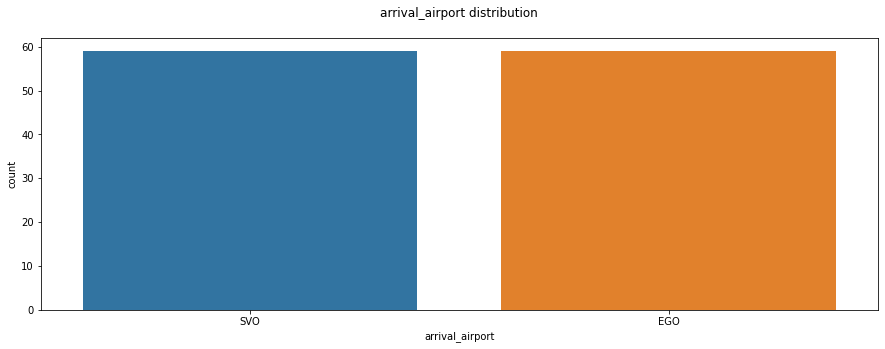

count     118
unique      2
top       SVO
freq       59
Name: arrival_airport, dtype: object

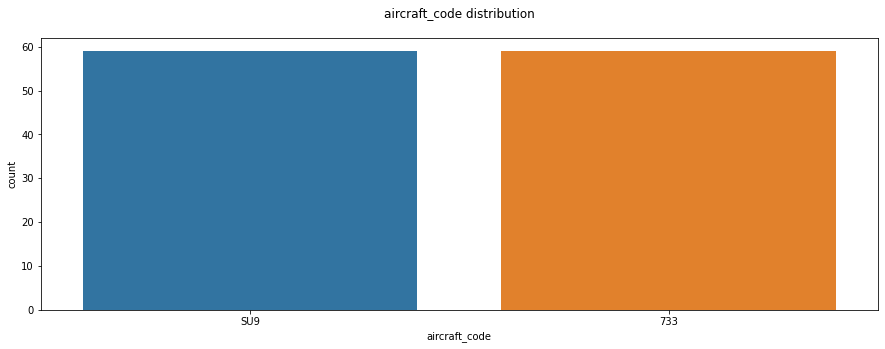

count     118
unique      2
top       SU9
freq       59
Name: aircraft_code, dtype: object

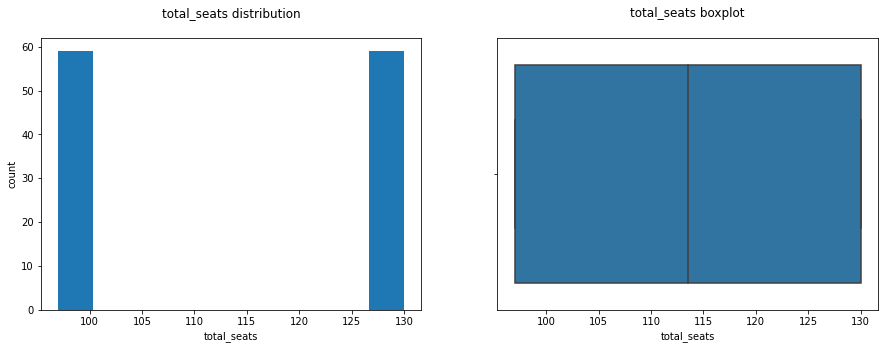

count    118.000000
mean     113.500000
std       16.570363
min       97.000000
25%       97.000000
50%      113.500000
75%      130.000000
max      130.000000
Name: total_seats, dtype: float64

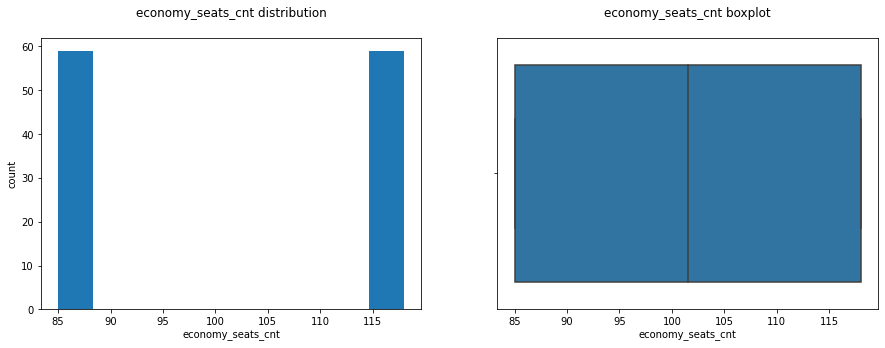

count    118.000000
mean     101.500000
std       16.570363
min       85.000000
25%       85.000000
50%      101.500000
75%      118.000000
max      118.000000
Name: economy_seats_cnt, dtype: float64

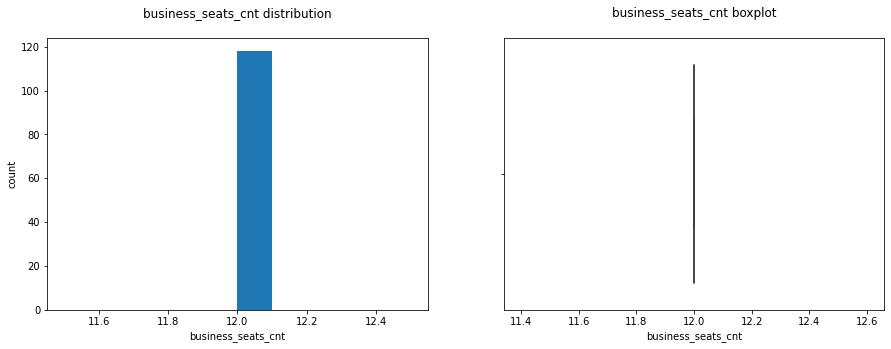

count    118.0
mean      12.0
std        0.0
min       12.0
25%       12.0
50%       12.0
75%       12.0
max       12.0
Name: business_seats_cnt, dtype: float64

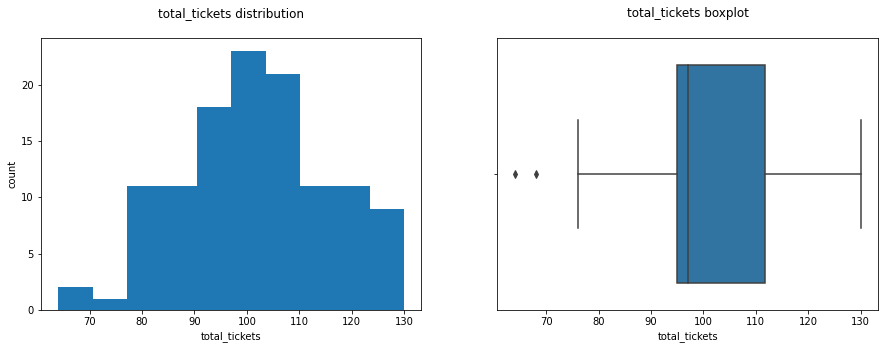

count    118.000000
mean     101.652542
std       14.295643
min       64.000000
25%       95.000000
50%       97.000000
75%      111.750000
max      130.000000
Name: total_tickets, dtype: float64

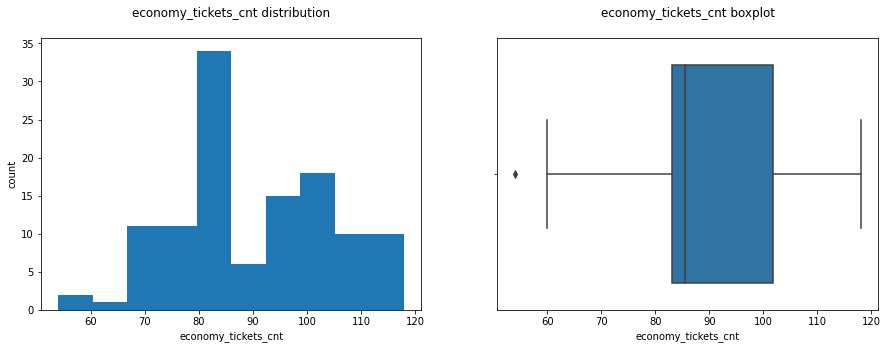

count    118.000000
mean      90.864407
std       14.028003
min       54.000000
25%       83.000000
50%       85.500000
75%      101.750000
max      118.000000
Name: economy_tickets_cnt, dtype: float64

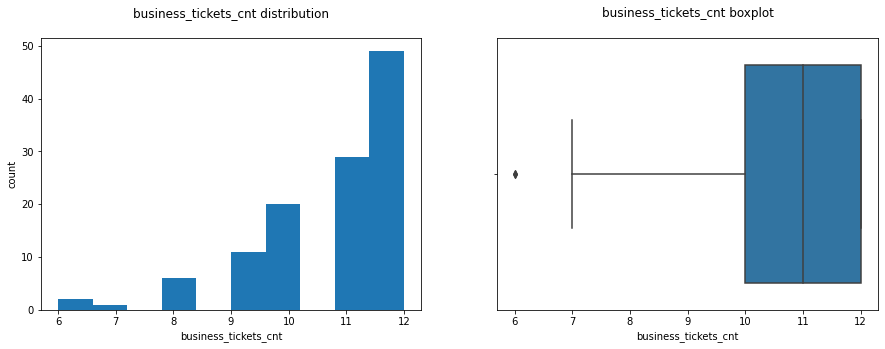

count    118.000000
mean      10.788136
std        1.395057
min        6.000000
25%       10.000000
50%       11.000000
75%       12.000000
max       12.000000
Name: business_tickets_cnt, dtype: float64

In [104]:
#исключим признаки: flight_id, так как он уникален, и departure_airport , так как аэропорт единственный
for feature in new_df.drop(['flight_id', 'departure_airport'], axis=1):
    if new_df[feature].dtype == 'object':
        get_cat(new_df, feature, height=5)
    elif new_df[feature].dtype == 'int64':
        get_num(new_df, feature)

Видим, что интересующие нас рейсы летают в двух направлениях - Шереметьево и Белгород, на самолетах типа Boeing 737-300 и Sukhoi Superjet 100.

**Оценка прибыльности.**

Из имеющихся у нас данных оценку прибыльности рейсов можно расчитать следующими вариантами:
1. Исходя из того, что если загрузка кресел меньше, чем 75%, то рейс становится нерентабельным (https://www.kommersant.ru/doc/3246832).
2. По недополученной прибыли от убыточных рейсов.

In [105]:
#рассомтрим первый вариант расчета
new_df['full_seats'] = np.round(new_df['total_tickets'] * 100 / new_df['total_seats'],2)

drop_flights1 = (new_df['full_seats'] < 75)
new_df[drop_flights1]

,flight_id,scheduled_departure,departure_airport,arrival_airport,aircraft_code,flight_duration_minutes,total_seats,economy_seats_cnt,business_seats_cnt,total_tickets,economy_tickets_cnt,business_tickets_cnt,total_amount,economy_tickets_amount,business_tickets_amount,full_seats
2,136122,2017-01-08 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,97,87,10,1431000.0,1065000.0,366000.0,74.62
38,136360,2017-02-05 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,97,86,11,1455400.0,1052800.0,402600.0,74.62
77,136642,2017-01-30 09:25:00+00:00,AAQ,EGO,SU9,49.0,97,85,12,64,54,10,531000.0,342000.0,189000.0,65.98
102,136807,2017-02-23 09:25:00+00:00,AAQ,EGO,SU9,50.0,97,85,12,68,60,8,531000.0,379800.0,151200.0,70.10


Вывод: данный результат показал необходимость исключения рейсов 136122, 136360, 136642 и 136807.

In [106]:
#рассмотрим второй вариант расчета
new_df['economy_tickets_cost'] = new_df['economy_tickets_amount'] / \
                                       new_df['business_tickets_cnt']
new_df['business_tickets_cost'] = new_df['business_tickets_amount'] / \
                                       new_df['business_tickets_cnt']
new_df['full_amount'] = new_df['economy_tickets_cost'] * \
                              new_df['business_seats_cnt'] + \
                              new_df['business_tickets_cost'] * new_df['business_seats_cnt']
#будем отталкиваться от 25% недополученной прибыли
drop_flights2 = ((new_df['total_amount'] * 100 / new_df['full_amount']) < 75)
new_df[drop_flights2]

,flight_id,scheduled_departure,departure_airport,arrival_airport,aircraft_code,flight_duration_minutes,total_seats,economy_seats_cnt,business_seats_cnt,total_tickets,economy_tickets_cnt,business_tickets_cnt,total_amount,economy_tickets_amount,business_tickets_amount,full_seats,economy_tickets_cost,business_tickets_cost,full_amount
16,136204,2017-02-23 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,107,101,6,1457800.0,1238200.0,219600.0,82.31,206366.666667,36600.0,2.915600e+06
21,136250,2017-02-08 10:05:00+00:00,AAQ,SVO,733,101.0,130,118,12,99,91,8,1407800.0,1115000.0,292800.0,76.15,139375.000000,36600.0,2.111700e+06
35,136345,2017-01-24 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,108,100,8,1517600.0,1224800.0,292800.0,83.08,153100.000000,36600.0,2.276400e+06
40,136383,2017-01-25 10:05:00+00:00,AAQ,SVO,733,102.0,130,118,12,106,98,8,1493200.0,1200400.0,292800.0,81.54,150050.000000,36600.0,2.239800e+06
54,136464,2017-01-09 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,100,93,7,1398000.0,1141800.0,256200.0,76.92,163114.285714,36600.0,2.396571e+06
58,136486,2017-02-02 10:05:00+00:00,AAQ,SVO,733,101.0,130,118,12,107,99,8,1505400.0,1212600.0,292800.0,82.31,151575.000000,36600.0,2.258100e+06
102,136807,2017-02-23 09:25:00+00:00,AAQ,EGO,SU9,50.0,97,85,12,68,60,8,531000.0,379800.0,151200.0,70.10,47475.000000,18900.0,7.965000e+05
109,136844,2017-02-28 09:25:00+00:00,AAQ,EGO,SU9,50.0,97,85,12,79,73,6,575100.0,461700.0,113400.0,81.44,76950.000000,18900.0,1.150200e+06
116,136887,2017-01-20 09:25:00+00:00,AAQ,EGO,SU9,49.0,97,85,12,78,70,8,595200.0,444000.0,151200.0,80.41,55500.000000,18900.0,8.928000e+05


Вывод: результат второго варианта показал необходимость исключения следующих рейсов: 136204, 136250, 136345, 136383, 136464, 136486, 136807, 136844 и 136887.

In [130]:
d_df = new_df[drop_flights2].append(new_df[drop_flights1])
drop_df = d_df.drop_duplicates()
drop_df

,flight_id,scheduled_departure,departure_airport,arrival_airport,aircraft_code,flight_duration_minutes,total_seats,economy_seats_cnt,business_seats_cnt,total_tickets,economy_tickets_cnt,business_tickets_cnt,total_amount,economy_tickets_amount,business_tickets_amount,full_seats,economy_tickets_cost,business_tickets_cost,full_amount
16,136204,2017-02-23 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,107,101,6,1457800.0,1238200.0,219600.0,82.31,206366.666667,36600.0,2.915600e+06
21,136250,2017-02-08 10:05:00+00:00,AAQ,SVO,733,101.0,130,118,12,99,91,8,1407800.0,1115000.0,292800.0,76.15,139375.000000,36600.0,2.111700e+06
35,136345,2017-01-24 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,108,100,8,1517600.0,1224800.0,292800.0,83.08,153100.000000,36600.0,2.276400e+06
40,136383,2017-01-25 10:05:00+00:00,AAQ,SVO,733,102.0,130,118,12,106,98,8,1493200.0,1200400.0,292800.0,81.54,150050.000000,36600.0,2.239800e+06
54,136464,2017-01-09 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,100,93,7,1398000.0,1141800.0,256200.0,76.92,163114.285714,36600.0,2.396571e+06
58,136486,2017-02-02 10:05:00+00:00,AAQ,SVO,733,101.0,130,118,12,107,99,8,1505400.0,1212600.0,292800.0,82.31,151575.000000,36600.0,2.258100e+06
102,136807,2017-02-23 09:25:00+00:00,AAQ,EGO,SU9,50.0,97,85,12,68,60,8,531000.0,379800.0,151200.0,70.10,47475.000000,18900.0,7.965000e+05
109,136844,2017-02-28 09:25:00+00:00,AAQ,EGO,SU9,50.0,97,85,12,79,73,6,575100.0,461700.0,113400.0,81.44,76950.000000,18900.0,1.150200e+06
116,136887,2017-01-20 09:25:00+00:00,AAQ,EGO,SU9,49.0,97,85,12,78,70,8,595200.0,444000.0,151200.0,80.41,55500.000000,18900.0,8.928000e+05
2,136122,2017-01-08 10:05:00+00:00,AAQ,SVO,733,100.0,130,118,12,97,87,10,1431000.0,1065000.0,366000.0,74.62,106500.000000,36600.0,1.717200e+06


In [128]:
a = new_df.total_amount.max()
b = drop_df.total_amount.max()
print(a,b)

1886000.0 1517600.0


In [129]:
drop_df.total_amount.sort_values(ascending=False)

35     1517600.0
58     1505400.0
40     1493200.0
16     1457800.0
38     1455400.0
2      1431000.0
21     1407800.0
54     1398000.0
116     595200.0
109     575100.0
77      531000.0
102     531000.0
Name: total_amount, dtype: float64

In [117]:
drop_df.total_amount.sum()

14429500.0

In [118]:
new_df.total_amount.sum()

138827700.0

In [119]:
c = new_df.total_amount.sum()- drop_df.total_amount.sum()
c

124398200.0